### This notebook is the benchmark notebook, where test results of each test notebook is combined together

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import os
import sys
sys.path.append('..')
from Framework.visualisation import *
from Framework.utils import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [ ]:
def plot_results(benchmark,normalize = True):
    if normalize:
        benchmark_norm = benchmark.iloc[:,2:-3].div(benchmark.sum(axis=1), axis=0)
        key = 'Normalized'
    else:
        benchmark_norm = benchmark.iloc[:,2:-3]
        key = 'Un-Normalized'
    plt.figure()
    y = np.arange(len(benchmark_norm.columns))
    col_labels = np.array(benchmark_norm.columns)
    for i in range(len(benchmark)):
        y_pos = y + i * (1/(2*len(col_labels)))
        plt.barh(y_pos,benchmark_norm.iloc[i,:],height = 1/(2*len(col_labels)),label = benchmark['Data_Type'][i] +  benchmark['Explainer_Type'][i][:3] +benchmark['Model_Type'][i][:3])
    plt.yticks([r + (1/(len(col_labels))) for r in range(len(y))], col_labels)
    plt.legend()
    plt.title(key + ' test errors in different datasets vs. method used (Trained over {0} via explainer {1} & model {2})'.format(benchmark.iloc[0,-3],benchmark.iloc[0,-2],benchmark.iloc[0,-1]))

In [ ]:
def label_vs(row,branch1,branch2):
    if row[branch1] < row[branch2] :
        return branch1
    elif row[branch1] > row[branch2] :
        return branch2
    else :
        return 'Draw'

In [ ]:
def numerate_vs(row,branch1,branch2):
    if row['Vs_results'] == branch1 :
        return 1
    elif row['Vs_results'] == branch2 :
        return 2
    else :
        return 0

In [ ]:
def visualize_vs(benchmark_df,branch1,branch2,label_opt = None):
    bench_b1_vs_b2 = benchmark_df.copy()
    bsl1 = bench_b1_vs_b2.groupby('Dataset_name').agg({branch1 : min})
    bsl2 = bench_b1_vs_b2.groupby('Dataset_name').agg({branch2 : min})
    for j in range(len(bench_b1_vs_b2['Dataset_name'])):
        bench_b1_vs_b2[branch1].iloc[j] = bsl1.loc[bench_b1_vs_b2['Dataset_name'].iloc[j]][0]
        bench_b1_vs_b2[branch2].iloc[j] = bsl2.loc[bench_b1_vs_b2['Dataset_name'].iloc[j]][0]
    bench_b1_vs_b2['Vs_results'] = bench_b1_vs_b2.apply(lambda x : label_vs(x,branch1,branch2) ,axis = 1)
    bench_df_grouped = bench_b1_vs_b2.groupby('Vs_results').agg({'Dataset_name':'nunique'})
    bench_df_grouped.reset_index(inplace = True)
    bench_df_grouped.columns = ['Comparison Winner','Number of Wins']
    bench_df_grouped_cat = bench_b1_vs_b2.groupby(['Dataset_name','Vs_results']).agg({'Dataset_name':'nunique'})
    bench_df_grouped_cat.columns = ['Dataset Index']
    bench_df_grouped_cat['Dataset Index'] = np.arange(bench_df_grouped_cat.shape[0])
    bench_df_grouped_cat.reset_index(inplace = True)

    ax1 = sns.barplot(y = 'Number of Wins',x = 'Comparison Winner',data = bench_df_grouped)
    ax2 = sns.catplot(x = 'Vs_results',y ='Dataset Index',hue = 'Dataset_name',data = bench_df_grouped_cat)
    if label_opt is None:
        ax2.set(xlabel='Better Performance',ylabel = 'Datasets',yticks = np.arange(bench_df_grouped_cat.shape[0]))
        ax2.set_yticklabels(list(bench_df_grouped_cat['Dataset_name']))
        plt.show()
    else:
        label_opt_list = [label_opt[i] for i in bench_df_grouped['Comparison Winner']]
        print(label_opt_list)
        ax1.set_xticklabels(label_opt_list)
        ax2.set_xticklabels(label_opt_list)
        ax2.set(xlabel='Better Performance',ylabel = 'Datasets',yticks = np.arange(bench_df_grouped_cat.shape[0]))
        ax2.set_yticklabels(list(bench_df_grouped_cat['Dataset_name']))
        plt.show()        

In [ ]:
from os import listdir
#%run "Shapley_Clustering_Boston_Dataset.ipynb"
#%run "Shapley_Clustering_Crime_Dataset.ipynb"

for c in [0,3,4,6,7]:
    for nC in [2,4]:
        for i in ['Original']:
            for j in ['Linear']:
                for k in ['XGBoost']:
                    !python Shapley_Clustering_Blackbox.py $i $j $k $nC $c

In [ ]:
import shap
for i in range(1,2):
    !python Shapley_Clustering_PCA_Blackbox.py Original-PCA Linear XGBoost 3 $i

In [ ]:
for i in range(1,2):
    !python ../Framework/custom_sklearn_pipeline.py Original XGBoost XGBoost 3 $i

In [ ]:
for c in range(1):
    for nC in [3,5]:
        for i in ['Original-PCA']:
            for j in ['Linear','XGBoost']:
                for k in ['XGBoost']:
                    !python Shapley_Clustering_PCA_Blackbox.py $i $j $k $nC $c

In [6]:
benchmark_df = pd.read_csv('../Data/5-fold-linear-xgb-test.txt')
runtime_df = pd.read_csv('../Data/train_runtime.txt')
complexity_df = pd.read_csv('../Data/test_complexity.txt')

In [ ]:
#benchmark_df = benchmark_df[benchmark_df['Explainer_Type'] == 'XGBoost']
benchmark_df.head()

In [ ]:
bsl1 = benchmark_df.groupby('Dataset_name').agg({'S1' : min})
bsl2 = benchmark_df.groupby('Dataset_name').agg({'S2' : min})
bsl1

In [ ]:
for j in range(len(benchmark_df['Dataset_name'])):
    benchmark_df['S1'].iloc[j] = bsl1.loc[benchmark_df['Dataset_name'].iloc[j]][0]
    benchmark_df['S2'].iloc[j] = bsl2.loc[benchmark_df['Dataset_name'].iloc[j]][0]

In [ ]:
#benchmark_df_min = benchmark_df[(benchmark_df['Explainer_model'] > benchmark_df['Shapley_ensemble']) & (benchmark_df['Original_ensemble'] > benchmark_df['Shapley_ensemble'])]
benchmark_df_min = benchmark_df
bsl1_improvement = (benchmark_df_min['S1'] - benchmark_df_min['S7']).divide(benchmark_df_min['S1'])
bsl2_improvement = (benchmark_df_min['S2'] - benchmark_df_min['S7']).divide(benchmark_df_min['S2'])
benchmark_df_min['Avg_Percentage_Improvement'] = round(100 * (bsl1_improvement+bsl2_improvement)/2,1)
benchmark_df_min = benchmark_df_min.loc[benchmark_df_min['Avg_Percentage_Improvement'] >= 0]
#benchmark_df_min = benchmark_df_min[benchmark_df_min['S7'] < benchmark_df_min['S10']]
benchmark_df_min[benchmark_df_min['Cluster_count'] > 1]

In [7]:
benchmark_df_no_c1 = benchmark_df[benchmark_df['Cluster_count'] > 1]
benchmark_df_only_c1 = benchmark_df[benchmark_df['Cluster_count'] == 1]
complexity_df_no_c1 = complexity_df[complexity_df['Cluster_count'] > 1]
complexity_df_only_c1 = complexity_df[complexity_df['Cluster_count'] == 1]
runtime_df_no_c1 = runtime_df[runtime_df['Cluster_count'] > 1]
runtime_df_only_c1 = runtime_df[runtime_df['Cluster_count'] == 1]
benchmark_df_no_c1.head()

,Dataset_name,B1,B2,B4,B5,B7,B8,Cluster_count
1,Admissions,0.071,0.072,0.064,0.073,0.066,0.073,2
2,Admissions,0.071,0.077,0.068,0.080,0.065,0.079,3
3,Admissions,0.071,0.079,0.079,0.077,0.068,0.078,4
4,Admissions,0.071,0.075,0.076,0.077,0.071,0.077,5
5,Admissions,0.071,0.085,0.073,0.082,0.066,0.081,6


In [ ]:
visualize_pairvs(benchmark_df_no_c1,'B1','B2')

In [ ]:
set_branch_best(benchmark_df_no_c1)

In [ ]:
visualize_pairvs_2(benchmark_df_only_c1,'B4','B7',{'Draw':'Draw','B4':'Branch X','B7':'Branch Y'},0.001)
#compare_branch_best_runtime(benchmark_df_only_c1,runtime_only_c1,'B1','B4',{'Draw':'Draw','B1':'B1','B4':'B3'})
#compare_branch_best_complexity(benchmark_df_only_c1,complexity_df_only_c1,'B1','B4',{'Draw':'Draw','B1':'B1','B4':'B3'})

In [ ]:
visualize_pairvs(benchmark_df_no_c1,'B2','B8')

In [ ]:
visualize_pairvs_2(benchmark_df_no_c1,'B5','B8',{'Draw':'Draw','B5':'Branch 5','B8':'Branch 8'},0.1)
#compare_branch_best_runtime(benchmark_df_no_c1,runtime_df_no_c1,'B2','B5')
#compare_branch_best_complexity(benchmark_df_no_c1,complexity_df_no_c1,'B2','B5')

In [ ]:
benchmark_mins,benchmark_min_idx = get_branch_mins(benchmark_df)
benchmark_mins['Vs_results'] = benchmark_mins.apply(lambda x : label_vs_triple(x,['B2','B5','B8'],0.001) ,axis = 1)

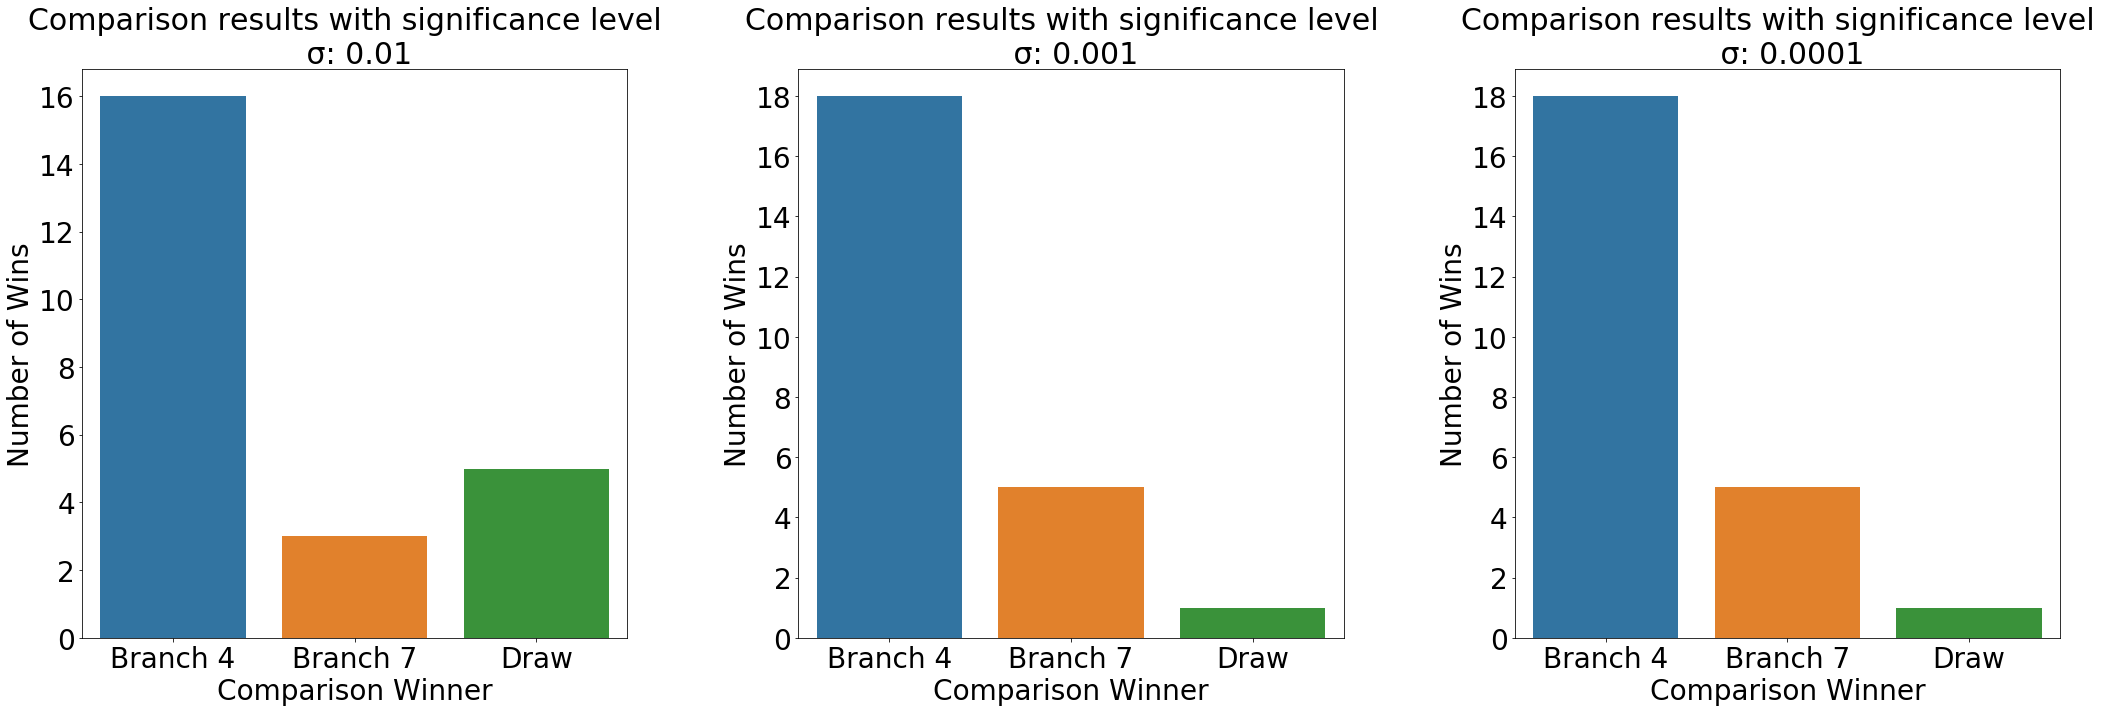

In [30]:
visualize_multiple_vs(benchmark_df_no_c1,['B7','B4'],{'Draw':'Draw','B4':'Branch 4','B1':'Branch 1','B7':'Branch 7'},0.1)

In [ ]:
df_temp = pd.DataFrame(['B5'],columns =['Vs_results'])
df_temp['Dataset_name'] = 0
df_temp

In [ ]:
visualize_pairvs(benchmark_df_no_c1,'B5','B8')

In [ ]:
visualize_pairvs_2(benchmark_df_no_c1,'B5','B8',None,0.001)
compare_branch_best_runtime(benchmark_df_no_c1,runtime_df_no_c1,'B5','B8')
compare_branch_best_complexity(benchmark_df_no_c1,complexity_df_no_c1,'B5','B8')

In [ ]:
#S5 vs S9
visualize_pairvs(benchmark_df_only_c1,'S6','S10',label_opt = {'Draw':'Draw','S6':'S5','S10':'S9'})

In [ ]:
#S6 vs S10
visualize_pairvs(benchmark_df_no_c1,'S6','S10')

In [ ]:
data_dict= scatter_datasets(benchmark_df_no_c1,'B1','B5')

In [ ]:
dataset_dict = dataset_stats(26)

In [ ]:
data_df = pd.DataFrame(dataset_dict).transpose()
data_df.reset_index(inplace = True)
data_df.to_csv('dataset_stats.csv', index=False)

In [ ]:
scatter_datasets(benchmark_df_no_c1,'B2','B5')

In [ ]:
benchmark_df2 = benchmark_df.iloc[:,:7]
benchmark_df2.to_csv('stats_import_data.csv', sep = ',', index = False)

In [ ]:
bench_datatype_grouped = benchmark_df_min.groupby('Data_Type').agg({'Percentage_Improvement':np.mean})
bench_dataset_grouped = benchmark_df_min.groupby(['Dataset_name']).agg({'Percentage_Improvement':np.mean, 'Data_Type':'nunique'})
bench_dataset_grouped = bench_dataset_grouped[bench_dataset_grouped['Data_Type'] == 1]
benchmark_df_min = benchmark_df_min[benchmark_df_min['Dataset_name'] != 'NYE_Airbnb']
bench_datatype_grouped = benchmark_df_min.groupby(['Data_Type','Dataset_name']).agg({'Percentage_Improvement':np.mean})
bench_dataset_grouped = benchmark_df_min.groupby(['Dataset_name','Data_Type']).agg({'Percentage_Improvement':np.mean})
bench_datatype_grouped = bench_datatype_grouped.groupby('Data_Type').mean()
bench_dataset_grouped

In [ ]:
g = sns.barplot(y =bench_datatype_grouped.index ,x ='Percentage_Improvement',data = bench_datatype_grouped)
g.set_title ('Percentage improvement over all methods and datasets for given feature space')

In [ ]:
g= sns.barplot(y =bench_dataset_grouped.index ,x ='Percentage_Improvement',data = bench_dataset_grouped)
g.set_title('Percentage improvement in rmse over all models for given dataset')

In [ ]:
data_min = benchmark_df_min.groupby(['Data_Type','Explainer_Type','Ensemble_model_Type']).agg({'Dataset_name':'nunique','Percentage_Improvement':np.mean})
data_min['Percentage_Improvement'] = round(data_min['Percentage_Improvement'],1)
data_min.columns = ['Dataset_count','Percentage_Improvement']
best_params = data_min['Dataset_count'].idxmax()

In [ ]:
data_min

In [ ]:
params_grouped = benchmark_df_min.groupby(['Data_Type','Explainer_Type','Ensemble_model_Type','Dataset_name'])
params_grouped_df = params_grouped.agg({'Explainer_model' : min ,'Original_ensemble':min, 'Shapley_ensemble' : min,'Percentage_Improvement':np.mean})
best_params_results = params_grouped_df.loc[best_params]

In [ ]:
list(best_params)

In [ ]:
#sets = benchmark_df[(benchmark_df.Data_Type == best_params[0]) & (benchmark_df.Explainer_Type == best_params[1]) & (benchmark_df.Ensemble_model_Type == best_params[2])]
#sets

In [ ]:
best_params_results

In [ ]:
g = sns.barplot(y =best_params_results.index ,x ='Percentage_Improvement',data = best_params_results)
g.set_title('Percentage improvement in rmse for Feature Space: {0} /Explainer(M_e): {1} /Leaf_Model(M_c1): {2}'.format(best_params[0],best_params[1],best_params[2]))

In [ ]:
data_min = benchmark_df.groupby(['Data_Type','Explainer_Type','Ensemble_model_Type','Dataset_name'])
data_min_df = data_min.agg({'Explainer_model' : min ,'Original_ensemble':min, 'Shapley_ensemble' : min})
data_real_min = data_min_df[(data_min_df['Explainer_model'] > data_min_df['Shapley_ensemble']) & (data_min_df['Original_ensemble'] > data_min_df['Shapley_ensemble'])]
bsl1_improvement = (data_real_min['Explainer_model'] - data_real_min['Shapley_ensemble']).divide(data_real_min['Explainer_model'])
bsl2_improvement = (data_real_min['Original_ensemble'] - data_real_min['Shapley_ensemble']).divide(data_real_min['Original_ensemble'])
data_real_min['Avg_Percentage_Improvement'] = 100 * (bsl1_improvement+bsl2_improvement)/2
data_real_min

In [ ]:
data_min = benchmark_df.groupby(['Data_Type','Explainer_Type','Ensemble_model_Type','Dataset_name'])
data_min_df = data_min.agg({'Explainer_model' : min ,'Original_ensemble':min, 'Shapley_ensemble' : min})
data_real_min = data_min_df[(data_min_df['Explainer_model'] > data_min_df['Shapley_ensemble']) & (data_min_df['Original_ensemble'] > data_min_df['Shapley_ensemble'])]
bsl1_improvement = (data_real_min['Explainer_model'] - data_real_min['Shapley_ensemble']).divide(data_real_min['Explainer_model'])
bsl2_improvement = (data_real_min['Original_ensemble'] - data_real_min['Shapley_ensemble']).divide(data_real_min['Original_ensemble'])
data_real_min['Avg_Percentage_Improvement'] = 100 * (bsl1_improvement+bsl2_improvement)/2
data_real_min

In [ ]:
data_real_min2 = data_real_min['Shapley_ensemble'].groupby(['Data_Type','Ensemble_model_Type','Explainer_Type']).count()
data_param_count = data_real_min2.groupby(['Data_Type','Explainer_Type','Ensemble_model_Type']).sum()
data_param_count

In [ ]:
data_min = benchmark_df.groupby(['Data_Type','Cluster_count','Explainer_Type','Ensemble_model_Type','Dataset_name'])
data_min_df = data_min.agg({'Explainer_model' : min ,'Original_ensemble':min, 'Shapley_ensemble' : min})
data_real_min = data_min_df[(data_min_df['Explainer_model'] > data_min_df['Shapley_ensemble']) & (data_min_df['Original_ensemble'] > data_min_df['Shapley_ensemble'])]
data_real_min

In [ ]:
data_real_min2 = data_real_min['Shapley_ensemble'].groupby(['Data_Type','Cluster_count','Ensemble_model_Type','Explainer_Type']).count()
data_param_count = data_real_min2.groupby(['Data_Type','Cluster_count','Explainer_Type','Ensemble_model_Type']).sum()
data_param_count

In [ ]:
benchmark_df = pd.read_csv('../Data/test_results_all_data.txt')
bsl1 = benchmark_df.groupby('Dataset_name').agg({'Explainer_model' : min})
bsl2 = benchmark_df.groupby('Dataset_name').agg({'Original_ensemble' : min})
for j in range(len(benchmark_df['Dataset_name'])):
    benchmark_df['Explainer_model'].iloc[j] = bsl1.loc[benchmark_df['Dataset_name'].iloc[j]][0]
    benchmark_df['Original_ensemble'].iloc[j] = bsl2.loc[benchmark_df['Dataset_name'].iloc[j]][0]
data_min = benchmark_df.groupby(['Data_Type','Explainer_Type','Ensemble_model_Type','Dataset_name'])
data_min_df = data_min.agg({'Explainer_model' : min ,'Original_ensemble':min, 'Shapley_ensemble' : min})
data_real_min = data_min_df[(data_min_df['Explainer_model'] > data_min_df['Shapley_ensemble']) & (data_min_df['Original_ensemble'] > data_min_df['Shapley_ensemble'])]
data_real_min

In [ ]:
data_real_min2 = data_real_min['Shapley_ensemble'].groupby(['Data_Type','Ensemble_model_Type','Explainer_Type']).count()
data_param_count = data_real_min2.groupby(['Data_Type','Explainer_Type','Ensemble_model_Type']).sum()
data_param_count

In [ ]:
data_min = benchmark_df.groupby(['Data_Type','Cluster_count','Explainer_Type','Ensemble_model_Type','Dataset_name'])
data_min_df = data_min.agg({'Explainer_model' : min ,'Original_ensemble':min, 'Shapley_ensemble' : min})
data_real_min = data_min_df[(data_min_df['Explainer_model'] > data_min_df['Shapley_ensemble']) & (data_min_df['Original_ensemble'] > data_min_df['Shapley_ensemble'])]
data_real_min

In [ ]:
data_real_min2 = data_real_min['Shapley_ensemble'].groupby(['Data_Type','Cluster_count','Ensemble_model_Type','Explainer_Type']).count()
data_param_count = data_real_min2.groupby(['Data_Type','Cluster_count','Explainer_Type','Ensemble_model_Type']).sum()
data_param_count

In [ ]:
benchmark_df_bst = benchmark_df_min[benchmark_df_min['Dataset_name'] == 'Amazon']
benchmark_df_org = benchmark_df_bst[(benchmark_df_bst['Data_Type'] == 'Original')]
benchmark_df_shap = benchmark_df_bst[(benchmark_df_bst['Data_Type'] == 'Shapley')]
benchmark_df_org.reset_index(inplace = True)
benchmark_df_shap.reset_index(inplace = True)

In [ ]:
benchmark_melted_org = pd.melt(benchmark_df_org.iloc[:,[2,3,4,5,7,8]] , id_vars = ['Explainer_Type','Ensemble_model_Type','Cluster_count'], value_vars= ['Explainer_model','Original_ensemble','Shapley_ensemble'])
#benchmark_melted_org.drop_duplicates(benchmark_melted_org.columns[[0,3,4]],inplace = True)
benchmark_melted_org.rename(columns = {'variable':'Model','value':'rmse'},inplace = True)
g= sns.catplot(x = 'Explainer_Type',y = 'rmse', hue = 'Model',col = 'Ensemble_model_Type',row = 'Cluster_count',kind = 'bar',data = benchmark_melted_org)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Test-rmse results for dataset: {0} with training via: {1}'.format(benchmark_df_org['Dataset_name'].iloc[0], benchmark_df_org['Data_Type'].iloc[0]), fontsize=16)

In [ ]:
benchmark_melted_shap = pd.melt(benchmark_df_shap.iloc[:,[2,3,4,5,7,8]] , id_vars = ['Explainer_Type','Ensemble_model_Type','Cluster_count'], value_vars= ['Explainer_model','Original_ensemble','Shapley_ensemble'])
#benchmark_melted_shap.drop_duplicates(benchmark_melted_shap.columns[[0,3,4]],inplace = True)
benchmark_melted_shap.rename(columns = {'variable':'Model','value':'rmse'},inplace = True)
g= sns.catplot(x = 'Explainer_Type',y = 'rmse', hue = 'Model',col = 'Ensemble_model_Type',row = 'Cluster_count',kind = 'bar',data = benchmark_melted_shap)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Test-rmse results for dataset: {0} with training via: {1}'.format(benchmark_df_shap['Dataset_name'].iloc[0], benchmark_df_shap['Data_Type'].iloc[0]), fontsize=16)

In [31]:
benchmark_best = set_branch_best(benchmark_df_no_c1,'B1','B2','B4','B5','B7','B8')
benchmark_best_c1 = set_branch_best(benchmark_df_only_c1,'B4','B7')
#benchmark_best.reset_index(inplace = True,drop = True)

C:\Users\koral\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [35]:
benchmark_best['B3'] = [df[i][0] for i in range(df.shape[0])]
benchmark_best['B5'] = [df[i][1] for i in range(df.shape[0])]
#benchmark_best2 = pd.concat((benchmark_best,benchmark_best_c1.loc[:,['B4','B7']]),axis = 1)

ValueError: Length of values does not match length of index

In [34]:
df = np.array(benchmark_best_c1.loc[:,['B4','B7']])
df.shape

(24, 2)

In [37]:
benchmark_best2

,Dataset_name,B1,B2,B4,B5,B7,B8,Cluster_count,B4,B7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.071,0.066
1,Admissions,0.071,0.072,0.064,0.073,0.065,0.073,2.0,NaN,NaN
2,Admissions,0.071,0.072,0.064,0.073,0.065,0.073,3.0,NaN,NaN
3,Admissions,0.071,0.072,0.064,0.073,0.065,0.073,4.0,NaN,NaN
4,Admissions,0.071,0.072,0.064,0.073,0.065,0.073,5.0,NaN,NaN
5,Admissions,0.071,0.072,0.064,0.073,0.065,0.073,6.0,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,166.962,189.723
7,Amazon,166.873,163.930,172.224,161.275,193.768,161.275,2.0,NaN,NaN
8,Amazon,166.873,163.930,172.224,161.275,193.768,161.275,3.0,NaN,NaN
9,Amazon,166.873,163.930,172.224,161.275,193.768,161.275,4.0,NaN,NaN


In [49]:
ar = np.array([df[i][0] for i in range(df.shape[0])])
benchmark_best['New_col'] = ar

ValueError: Length of values does not match length of index

In [40]:
benchmark_best_grouped  = benchmark_best.groupby('Dataset_name')['B1','B2','B4','B5','B7','B8'].min()
benchmark_best_c1_grouped  = benchmark_best_c1.groupby('Dataset_name')['B4','B7'].min()

In [ ]:
print(benchmark_best_grouped.to_latex(index = False))

In [ ]:
print(benchmark_best_grouped.transpose().to_latex())

In [41]:
benchmark_best_grouped

,B1,B2,B4,B5,B7,B8
Dataset_name,,,,,,
Admissions,0.071,0.072,0.064,0.073,0.065,0.073
Amazon,166.873,163.930,172.224,161.275,193.768,161.275
Auto Price,1129.769,1190.579,2002.525,1053.687,2249.064,1053.687
Balloon,0.074,0.074,0.078,0.074,0.078,0.074
Banking Data,0.083,0.083,0.086,0.083,0.088,0.082
Boston,3.118,3.027,3.595,3.100,3.950,3.100
CPU Activity,2.601,2.612,2.755,2.612,4.202,2.597
Crime,344.746,346.443,339.212,339.637,641.487,338.785
Diabetes,67.455,66.887,65.480,65.913,58.937,64.441


In [42]:
benchmark_best_c1_grouped

,B4,B7
Dataset_name,,
Admissions,0.071,0.066
Amazon,166.962,189.723
Auto Price,1115.416,1464.995
Balloon,0.074,0.074
Banking Data,0.083,0.086
Boston,3.096,3.558
CPU Activity,2.605,4.178
Crime,346.198,624.472
Diabetes,67.003,62.810


In [43]:
benchmark_best_grouped['B3'] = benchmark_best_c1_grouped['B4']
benchmark_best_grouped['B6'] = benchmark_best_c1_grouped['B7']
#benchmark_best_grouped.sort_values(by = ['B1','B2','B3','B4','B5','B6','B7','B8'],axis = 1)

In [44]:
benchmark_best_grouped.columns

Index(['B1', 'B2', 'B4', 'B5', 'B7', 'B8', 'B3', 'B6'], dtype='object')

In [45]:
new_col = sorted(benchmark_best_grouped.columns)

In [83]:
print(benchmark_best_grouped[new_col].to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &        B1 &        B2 &        B3 &        B4 &        B5 &        B6 &        B7 &        B8 \\
Dataset\_name    &           &           &           &           &           &           &           &           \\
\midrule
Admissions      &     0.071 &     0.072 &     0.071 &     0.064 &     0.073 &     0.066 &     0.065 &     0.073 \\
Amazon          &   166.873 &   163.930 &   166.962 &   172.224 &   161.275 &   189.723 &   193.768 &   161.275 \\
Auto Price      &  1129.769 &  1190.579 &  1115.416 &  2002.525 &  1053.687 &  1464.995 &  2249.064 &  1053.687 \\
Balloon         &     0.074 &     0.074 &     0.074 &     0.078 &     0.074 &     0.074 &     0.078 &     0.074 \\
Banking Data    &     0.083 &     0.083 &     0.083 &     0.086 &     0.083 &     0.086 &     0.088 &     0.082 \\
Boston          &     3.118 &     3.027 &     3.096 &     3.595 &     3.100 &     3.558 &     3.950 &     3.100 \\
CPU Activity    &     2.601 &     2.612 &     2

In [47]:
benchmark_best_grouped[new_col].to_csv('hello.csv',index = False)